# Chlorophyll vs Control (Masking SPECTRA's chlorophyll to only show output where there are observations at SeaWiFS)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Import all of the SeaWiFS data

In [6]:
# October, November and December of 1997 
seawifs_data = '/glade/derecho/scratch/gabyn/obs/SeaWiFS/interannual_1997_2010'
#seawifs_data = '/glade/derecho/scratch/gabyn/SeaWiFS_1998_2010/regrid/'
obs_1997 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1997.*.nc', recursive=True),
                      key=numericalSort)
ds_1997 = xr.open_mfdataset(obs_1997,concat_dim='time',combine='nested')

# All months of 1998
obs_1998 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1998.*.nc', recursive=True),
                      key=numericalSort)
ds_1998 = xr.open_mfdataset(obs_1998,concat_dim='time',combine='nested')

# All months of 1999
obs_1999 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_1999.*.nc', recursive=True),
                      key=numericalSort)
ds_1999 = xr.open_mfdataset(obs_1999,concat_dim='time',combine='nested')

# All months of 2000
obs_2000 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2000.*.nc', recursive=True),
                      key=numericalSort)
ds_2000 = xr.open_mfdataset(obs_2000,concat_dim='time',combine='nested')

# All months of 2001
obs_2001 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2001.*.nc', recursive=True),
                      key=numericalSort)
ds_2001 = xr.open_mfdataset(obs_2001,concat_dim='time',combine='nested')

# All months of 2002
obs_2002 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2002.*.nc', recursive=True),
                      key=numericalSort)
ds_2002 = xr.open_mfdataset(obs_2002,concat_dim='time',combine='nested')

# All months of 2003
obs_2003 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2003.*.nc', recursive=True),
                      key=numericalSort)
ds_2003 = xr.open_mfdataset(obs_2003,concat_dim='time',combine='nested')

# All months of 2004
obs_2004 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2004.*.nc', recursive=True),
                      key=numericalSort)
ds_2004 = xr.open_mfdataset(obs_2004,concat_dim='time',combine='nested')

# All months of 2005
obs_2005 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2005.*.nc', recursive=True),
                      key=numericalSort)
ds_2005 = xr.open_mfdataset(obs_2005,concat_dim='time',combine='nested')

# All months of 2006
obs_2006 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2006.*.nc', recursive=True),
                      key=numericalSort)
ds_2006 = xr.open_mfdataset(obs_2006,concat_dim='time',combine='nested')

# All months of 2007
obs_2007 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2007.*.nc', recursive=True),
                      key=numericalSort)
ds_2007 = xr.open_mfdataset(obs_2007,concat_dim='time',combine='nested')

# Only 10 months, February and March are Absent. 
obs_2008 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2008.*.nc', recursive=True),
                      key=numericalSort)
ds_2008 = xr.open_mfdataset(obs_2008,concat_dim='time',combine='nested')

# May, and December are absent. 
obs_2009 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2009.*.nc', recursive=True),
                      key=numericalSort)
ds_2009 = xr.open_mfdataset(obs_2009,concat_dim='time',combine='nested')

# All months of 2010
obs_2010 = sorted(glob.glob(f'{seawifs_data}/regrid_chl_ocx_SeaWiFS_2010.*.nc', recursive=True),
                      key=numericalSort)
ds_2010 = xr.open_mfdataset(obs_2010,concat_dim='time',combine='nested')

In [7]:
an_array = np.empty((180,360))
an_array[:] = np.NaN

ds_1997_new = np.stack([an_array,an_array,an_array,an_array,
                       an_array,an_array,an_array,an_array,
                       an_array,ds_1997.chl_ocx[0,:,:],
                       ds_1997.chl_ocx[1,:,:],
                       ds_1997.chl_ocx[2,:,:]])

ds_2008_new = np.stack([ds_2008.chl_ocx[0,:,:],
                        an_array,
                        an_array,
                       ds_2008.chl_ocx[1,:,:],
                       ds_2008.chl_ocx[2,:,:],
                       ds_2008.chl_ocx[3,:,:],
                       ds_2008.chl_ocx[4,:,:],
                       ds_2008.chl_ocx[5,:,:],
                       ds_2008.chl_ocx[6,:,:],
                       ds_2008.chl_ocx[7,:,:],
                       ds_2008.chl_ocx[8,:,:],
                       ds_2008.chl_ocx[9,:,:]])

#ds_2002_new = np.stack([ds_2002.chl_ocx[0,:,:],
#                       ds_2002.chl_ocx[1,:,:],
#                       ds_2002.chl_ocx[2,:,:],
#                        an_array,
#                        an_array,
#                       ds_2002.chl_ocx[3,:,:],
#                       ds_2002.chl_ocx[4,:,:],
#                       ds_2002.chl_ocx[5,:,:],
#                       ds_2002.chl_ocx[6,:,:],
#                       ds_2002.chl_ocx[7,:,:],
#                       ds_2002.chl_ocx[8,:,:],
#                       ds_2002.chl_ocx[9,:,:]])

ds_2009_new = np.stack([ds_2009.chl_ocx[0,:,:],
                       ds_2009.chl_ocx[1,:,:],
                       ds_2009.chl_ocx[2,:,:],
                       ds_2009.chl_ocx[3,:,:],
                        an_array,
                       ds_2009.chl_ocx[4,:,:],
                       ds_2009.chl_ocx[5,:,:],
                       ds_2009.chl_ocx[6,:,:],
                       ds_2009.chl_ocx[7,:,:],
                       ds_2009.chl_ocx[8,:,:],
                       ds_2009.chl_ocx[9,:,:],
                       an_array])

In [8]:
chl_ocx_SeaWiFS = np.stack([ds_1997_new, 
                            ds_1998.chl_ocx,
                           ds_1999.chl_ocx,
                           ds_2000.chl_ocx,
                           ds_2001.chl_ocx,
                           ds_2002.chl_ocx,
                           ds_2003.chl_ocx,
                           ds_2004.chl_ocx,
                           ds_2005.chl_ocx,
                           ds_2006.chl_ocx,
                           ds_2007.chl_ocx,
                            ds_2008_new,
                            ds_2009_new,
                           ds_2010.chl_ocx])

chl_ocx_SeaWiFS_mean = np.nanmean(chl_ocx_SeaWiFS,axis=0)

## Seasonality in both SPECTRA and SeaWIFS throughout the Arctic

In [9]:
file = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_2ndcycle_1990-2009_clim/regrid/'
ice_inds = sorted(glob.glob(f'{file}regrid_GNG595_ECOSYS_IFRAC.*.nc', recursive=True))
ice_ds = xr.open_mfdataset(ice_inds,combine='by_coords')

In [10]:
PAR_inds = sorted(glob.glob(f'{file}regrid_GNG595_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

In [11]:
# Model ice for every region 
ice_ao = np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts =np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))

# Model ice for every region 
PAR_ao = np.nanmean(PAR_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts =np.nanmean(PAR_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))


### Populate the months that do not have data

In [12]:

diat1_inds = sorted(glob.glob(f'{file}regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,concat_dim='time', combine='nested')

diat2_inds = sorted(glob.glob(f'{file}regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,concat_dim='time', combine='nested')

diat3_inds = sorted(glob.glob(f'{file}regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,concat_dim='time', combine='nested')

mp1_inds = sorted(glob.glob(f'{file}regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,concat_dim='time', combine='nested')

mp2_inds = sorted(glob.glob(f'{file}regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,concat_dim='time', combine='nested')

mp3_inds = sorted(glob.glob(f'{file}regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,concat_dim='time', combine='nested')

mp4_inds = sorted(glob.glob(f'{file}regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,concat_dim='time', combine='nested')

pp_inds = sorted(glob.glob(f'{file}regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,concat_dim='time', combine='nested')

diaz_inds = sorted(glob.glob(f'{file}regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,concat_dim='time', combine='nested')

In [13]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])

In [14]:
phytoChl_surface = np.nansum(phytoChl[:,:,0,:,:], axis =0) 

In [15]:
phytoChl_surface.shape

(12, 180, 360)

In [16]:
# Model Chlorophyll for every region (surface)
model_ao_seas = np.nanmean(phytoChl_surface[:,170:180,:], axis=(1,2))
model_cs_seas = np.nanmean(phytoChl_surface[:,149:170,0:25], axis = (1,2))
model_bs_seas = np.nanmean(phytoChl_surface[:,149:170,25:55], axis = (1,2))
model_ca_seas = np.nanmean(phytoChl_surface[:,149:170,55:110], axis = (1,2))
model_bb_seas = np.nanmean(phytoChl_surface[:,149:170,110:135], axis = (1,2))
model_ess_seas = np.nanmean(phytoChl_surface[:,149:170,325:360], axis = (1,2))
model_ls_seas = np.nanmean(phytoChl_surface[:,149:170,270:325], axis = (1,2))
model_ns_seas = np.nanmean(phytoChl_surface[:,149:170,155:205], axis = (1,2))
model_bts_seas =np.nanmean(phytoChl_surface[:,149:170,205:233], axis = (1,2))
model_ks_seas = np.nanmean(phytoChl_surface[:,149:170,233:270], axis = (1,2))

# Observed Chlorophyll for every region. 
obs_ao_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,170:180,:], axis=(1,2))
obs_cs_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,0:25], axis = (1,2))
obs_bs_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,25:55], axis = (1,2))
obs_ca_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,55:110], axis = (1,2))
obs_bb_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,110:135], axis = (1,2))
obs_ess_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,325:360], axis = (1,2))
obs_ls_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,270:325], axis = (1,2))
obs_ns_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,155:205], axis = (1,2))
obs_bts_seas =np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,205:233], axis = (1,2))
obs_ks_seas = np.nanmean(chl_ocx_SeaWiFS_mean[:,149:170,233:270], axis = (1,2))

## Font

In [17]:
import matplotlib.pyplot as plt

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

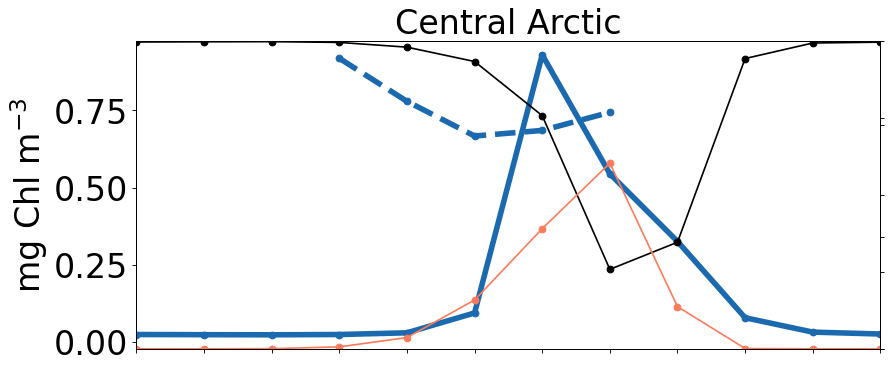

In [19]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Blues', 10)
cmap1=matplotlib.cm.get_cmap('Reds', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
lns1 = ax.plot(months,obs_ao_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
lns2 = ax.plot(months,model_ao_seas, '-o', color=cmap(7),linewidth=5,label='MARBL-SPECTRA')
#plt.yscale("log")
ax.set_ylabel('$mg Chl$ $m^{-3}$')
ax.set_title('Central Arctic')

ax2 = ax.twinx()
ax3 = ax.twinx(); #ax3.spines['right'].set_position(("axes", 1.2))
lns4=ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
lns5=ax3.plot(months, PAR_ao,'-o', color=cmap1(4),label='average PAR')

# added these lines
lns = lns1+lns2+lns4+lns5
labs = [l.get_label() for l in lns]
ax.legend().remove()
ax2.set_ylim(0,1); ax3.set_ylim(0,55);# ax.set_ylim(0.01,10)
#ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax.set_xticklabels('')

# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_CentralArctic_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

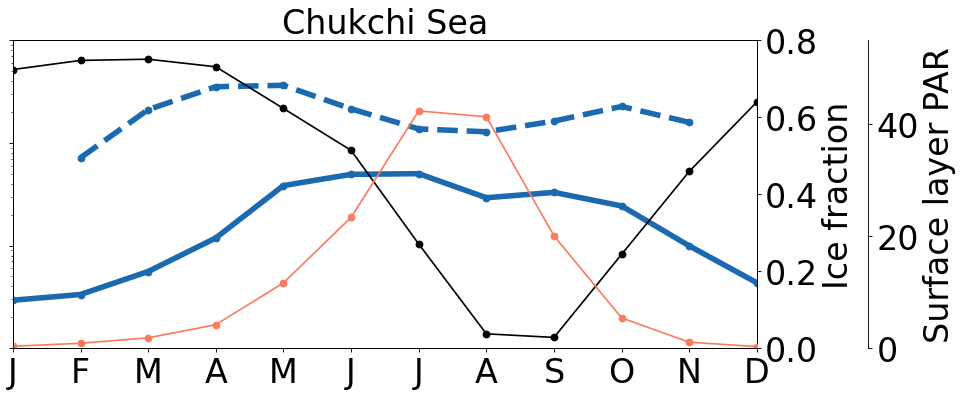

In [29]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_cs_seas, '-o', color=cmap(7),linewidth=5,label='MARBL-SPECTRA (surface)')
plt.yscale("log")
ax.set_title('Chukchi Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.15))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color=cmap1(4),label='PAR Average')

ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0.01,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_yticklabels('')

# Axes for chlorophyll 
#ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice fraction');ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface layer PAR');ax3.yaxis.label.set_color('k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')    
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Chukchi_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

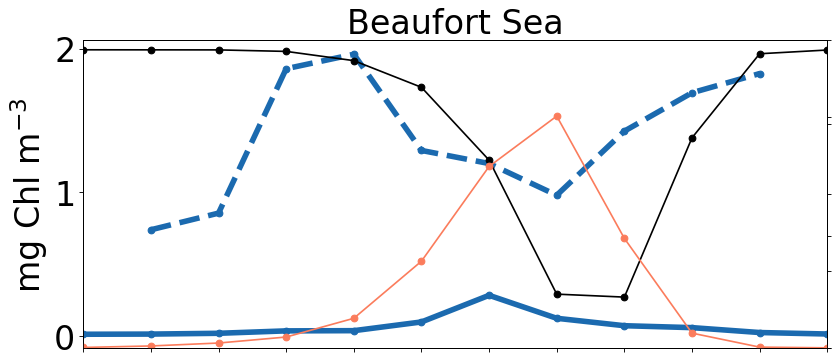

In [21]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_bs_seas, '-o', color=cmap(7),linewidth=5,label='MARBL-SPECTRA')
#plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$')
ax.set_title('Beaufort Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); #ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55); #ax.set_ylim(0.01,10)
#ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax.set_xticklabels('')
#ax.set_ylim(0.05,10)
# added these lines
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')   
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')   
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Beaufort_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

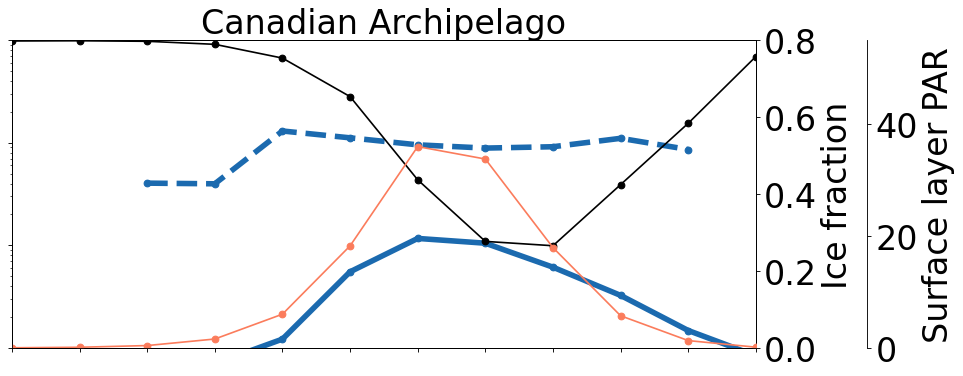

In [35]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')
fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_ca_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')

plt.yscale("log")
ax.set_title('Canadian Archipelago')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.15))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0.01,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
ax2.set_ylabel('Ice fraction');ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
ax3.set_ylabel('Surface layer PAR');ax3.yaxis.label.set_color('k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k') 
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Canadian_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

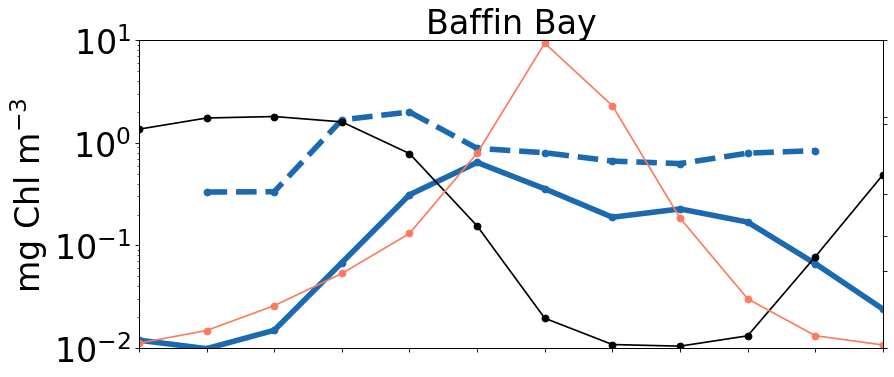

In [38]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')
fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_bb_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')

plt.yscale("log")
ax.set_title('Baffin Bay')
ax2 = ax.twinx()
ax3 = ax.twinx(); #ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color=cmap1(4),label='PAR Average')

#ax.set_ylim(0,2.5); 
ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0.01,10)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')   
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')   
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')    
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Baffin_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

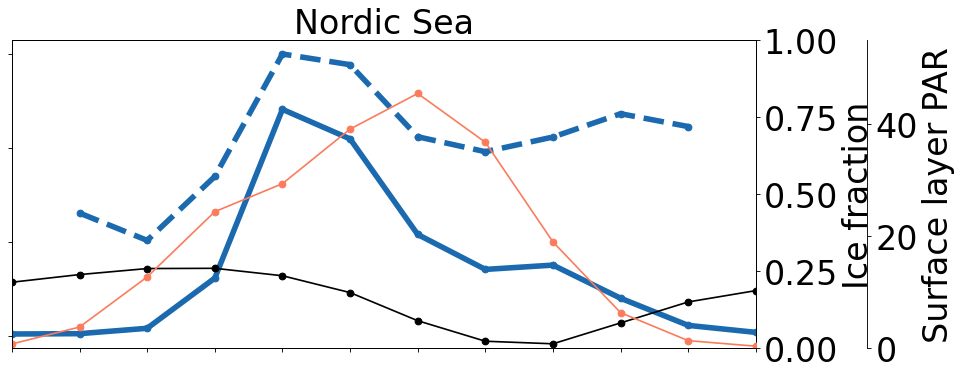

In [23]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_ns_seas, '-o', color=cmap(7),linewidth=5,label='MARBL-SPECTRA')

#plt.yscale("log")
ax.set_title('Nordic Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.15))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55); #ax.set_ylim(0.01,10)
#ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels('')
ax.set_xticklabels('') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice fraction');ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
ax3.set_ylabel('Surface layer PAR');ax3.yaxis.label.set_color('k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')     
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Nordic_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

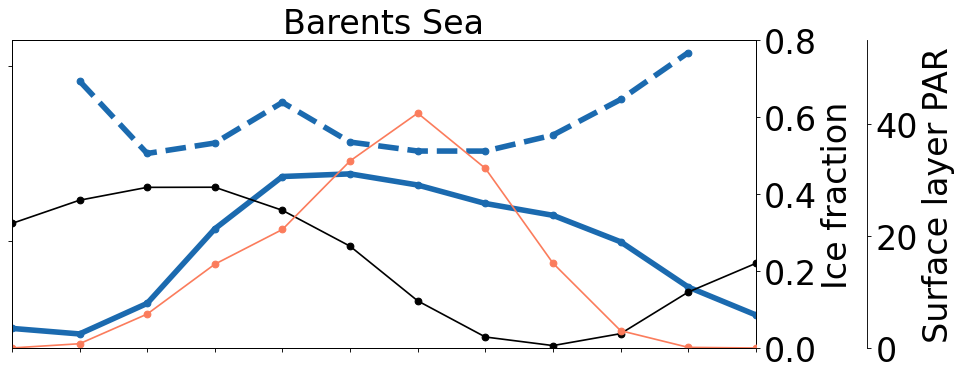

In [45]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_bts_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')
plt.yscale("log")
ax.set_title('Barents Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.15))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0,20)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels('')
ax.set_xticklabels('') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
ax2.set_ylabel('Ice fraction');ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
ax3.set_ylabel('Surface layer PAR');ax3.yaxis.label.set_color('k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Barents_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

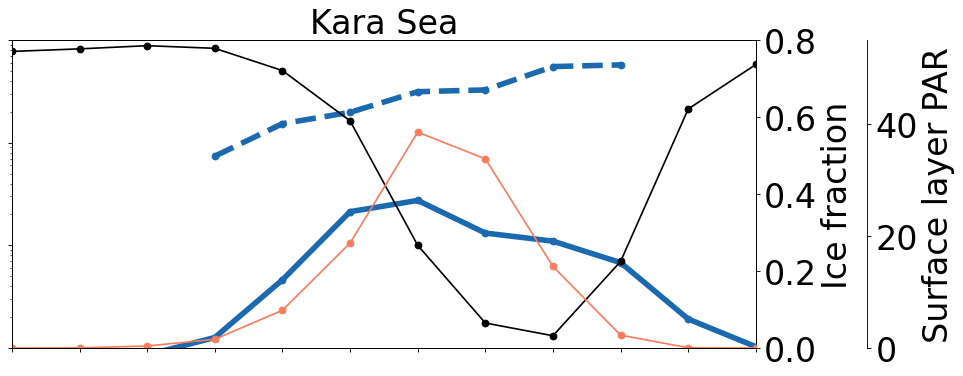

In [46]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')

ax.plot(months,model_ks_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')


plt.yscale("log")
ax.set_title('Kara Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.15))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55);ax.set_ylim(0.01,10)

ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels('')
ax.set_xticklabels('') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
ax2.set_ylabel('Ice fraction');ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
ax3.set_ylabel('Surface layer PAR');ax3.yaxis.label.set_color('k')  
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Kara_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

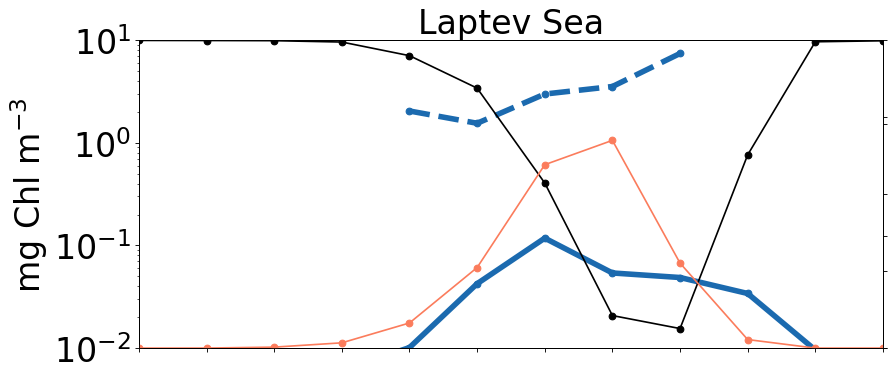

In [47]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_ls_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')
plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$')
ax.set_title('Laptev Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); #ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color=cmap1(4),label='PAR Average')

ax2.set_ylim(0,1); ax3.set_ylim(0,55); ax.set_ylim(0.01,10)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax.set_xticklabels('')
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k')  
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_Laptev_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

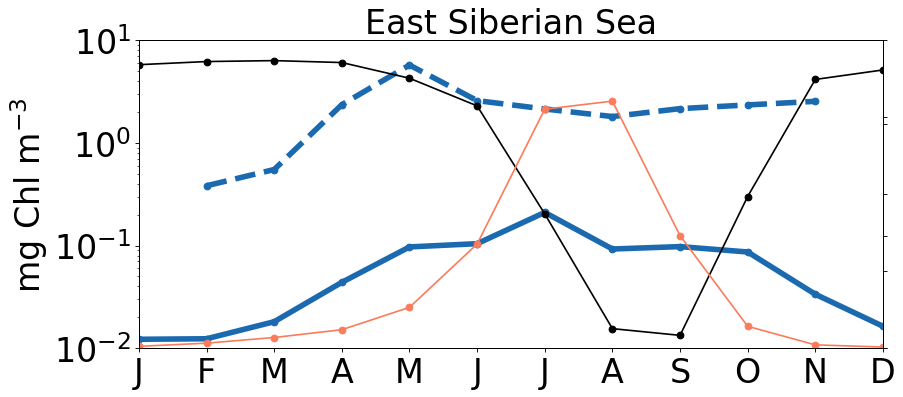

In [48]:
months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ess_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS')
ax.plot(months,model_ess_seas, '-o', color=cmap(7),linewidth=5,label='SPECTRA (surface)')
plt.yscale("log")
ax.set_ylabel('mg $Chl$ $m^{-3}$')
ax.set_title('East Siberian Sea')
ax2 = ax.twinx()
ax3 = ax.twinx(); #ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ess,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess,'-o', color=cmap1(4),label='PAR Average')
ax2.set_ylim(0,1); ax3.set_ylim(0,55);ax.set_ylim(0.01,10)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
# Axes for chlorophyll 
ax.set_ylabel('mg $Chl$ $m^{-3}$'); ax.yaxis.label.set_color('k') 
ax.spines['left'].set_color('k'); ax.tick_params(axis='y', colors='k')  
# Axes for Ice Fraction  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.spines['right'].set_color('k'); ax3.tick_params(axis='y', colors='k')     
ax.margins(x=0);
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/Chl_SPECTRA_SeaWIFS_EastSiberian_seasonality_remap_log.png', dpi=600, bbox_inches='tight')

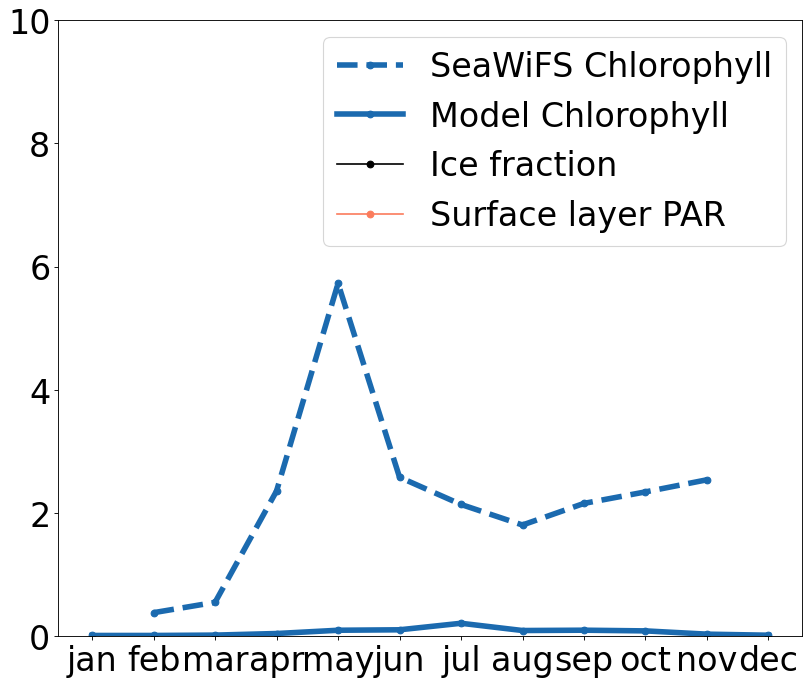

In [36]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
lns1=ax.plot(months,obs_ess_seas, '--o', color=cmap(7),linewidth=5,label='SeaWiFS Chlorophyll')
lns2=ax.plot(months,model_ess_seas, '-o', color=cmap(7),linewidth=5,label='Model Chlorophyll')
lns3=ax2.plot(months, ice_ess,'-o', color='k',label='Ice fraction')
lns4=ax3.plot(months, PAR_ess,'-o', color=cmap1(4),label='Surface layer PAR')

ax.set_ylim(0,10);
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right")

   

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/label_chl_log.png', dpi=600, bbox_inches='tight')